# Dragging gestures: Analysis

In [202]:
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import json
import os, shutil

In [203]:
iodModelName = 'kappa*length'
iodModelName = 'kappa'
# iodModelName = 'length'
centralTendency = 'mean'
# centralTendency = 'median'

funcIoDs = json.load(open('index_of_difficulty-' + iodModelName +'.json'))

In [239]:
# prepare folders and erase all figures
# only remove folders which are going to be changed by executing this script

figuresFoldername = 'figures'
drawingTimeHistogramsFoldername = 'drawing_time_histograms'
linearRegressionFoldername = 'linear_regressions'
takeScreenshots = True

drawingTimeHistogramsFolderPath = figuresFoldername + "/" + drawingTimeHistogramsFoldername + "/"
linearRegressionsFolderPath = figuresFoldername + "/" + linearRegressionFoldername \
    + "/" + iodModelName \
    + "/" + centralTendency + "/"
participantDataFolderPath = figuresFoldername + "/participants/"

def saveFigure(figurename):
    figurename = figurename.replace(' ', '_').replace('\n', '')
    if(takeScreenshots is True):
        plt.savefig(figurename)

def resetFigureFolder(foldername):
    if(os.path.exists(foldername)):
        shutil.rmtree(foldername)
    os.makedirs(foldername)

if(takeScreenshots is True):
    foldersToBeChanged = [
        drawingTimeHistogramsFolderPath,
        linearRegressionsFolderPath,
        participantDataFolderPath
    ]
    
    for foldername in foldersToBeChanged:
        print(foldername)
        resetFigureFolder(foldername)    


figures/drawing_time_histograms/
figures/linear_regressions/kappa/mean/
figures/participants/


In [205]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodsAsArray(projections, experimentModes):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            test = 0
            if projection == 'Cartesian' and experimentMode == 1:
                test = 1
            elif projection == 'Polar' and experimentMode == 0:
                test = 2
            elif projection == 'Polar' and experimentMode == 1:
                test = 3
    
            # iod = index of difficulty
            iods = funcIoDs[str(test)]
    
            for iod in iods:
                iodsArr.append(float(iods[iod]))
    return iodsArr

MAX_IOD = round(max(getIodsAsArray(PROJECTIONS, TEST_MODES)))
MAX_IOD += 0.2 * MAX_IOD

Columns: Index(['Participant name', 'Participant age', 'Participant handedness',
       'Device', 'Test mode', 'Logging timestamp', 'Function ID',
       'Function difficulty', 'Function projection', 'Drawing time',
       'Error approx', 'Expert Mouse User', 'Expert Graphic Tablet User'],
      dtype='object')


# Drawing time distribution per function

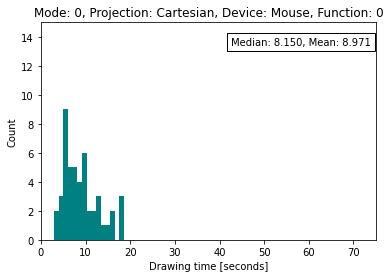

Mean:  8.9711285929375
Median:  8.14989686


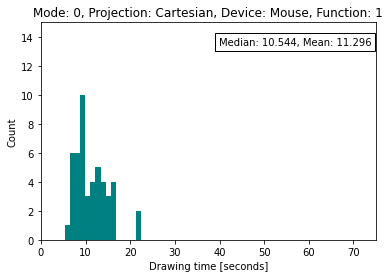

Mean:  11.295870671875
Median:  10.54449725


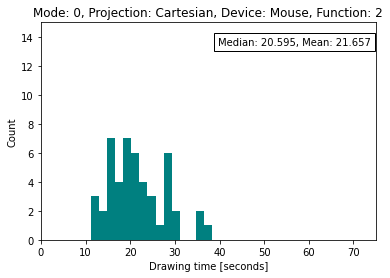

Mean:  21.656810596875
Median:  20.595363855


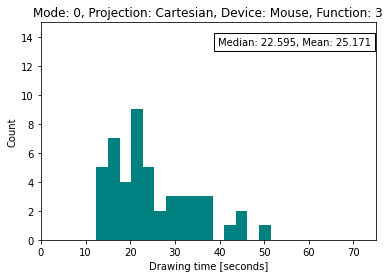

Mean:  25.17108643083333
Median:  22.595395205


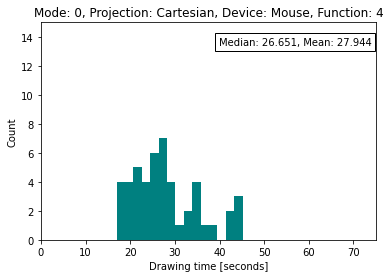

Mean:  27.944152956249997
Median:  26.65129125


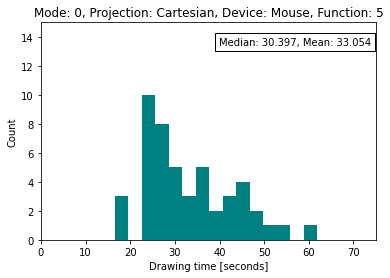

Mean:  33.05432457229167
Median:  30.396855475000002


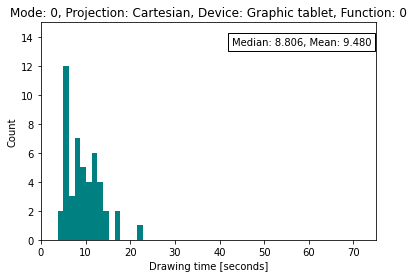

Mean:  9.480288733541668
Median:  8.805675148999999


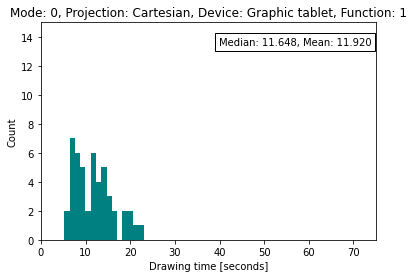

Mean:  11.920463547166667
Median:  11.64789081


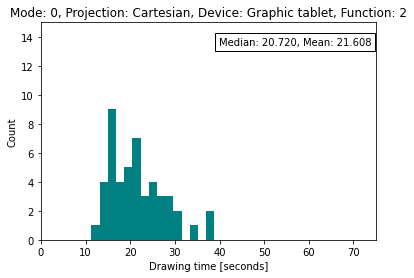

Mean:  21.60761583375
Median:  20.72018051


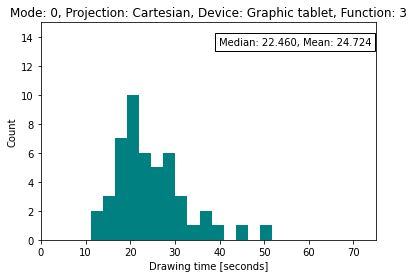

Mean:  24.724190413541667
Median:  22.46022713


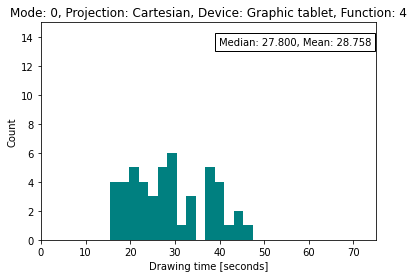

Mean:  28.757676910208335
Median:  27.80028677


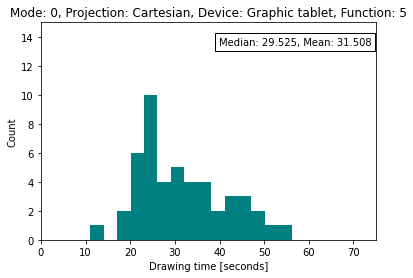

Mean:  31.508097807291666
Median:  29.525280000000002


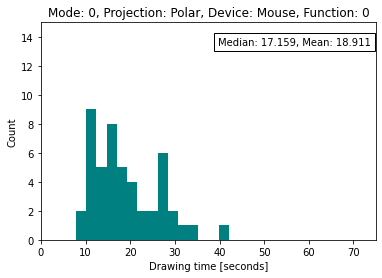

Mean:  18.910516470625
Median:  17.1585083


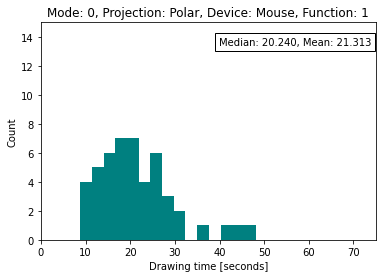

Mean:  21.313061878895834
Median:  20.240257385


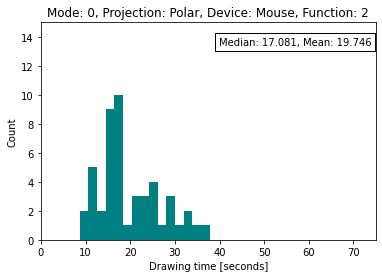

Mean:  19.74640122566667
Median:  17.08108473


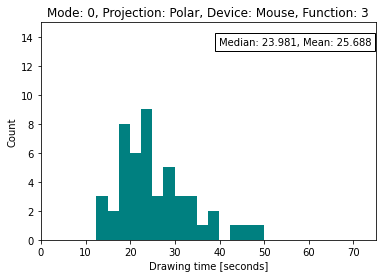

Mean:  25.687565693958334
Median:  23.98129797


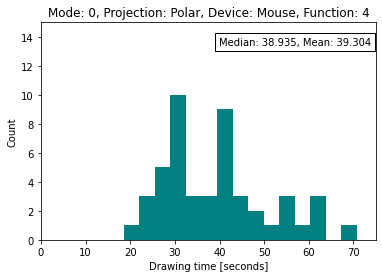

Mean:  39.30449399375001
Median:  38.93535352


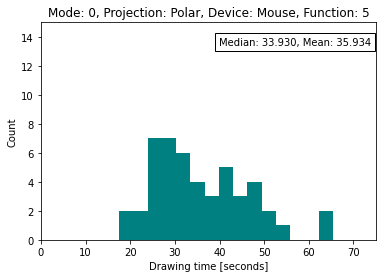

Mean:  35.934396529999994
Median:  33.93039942


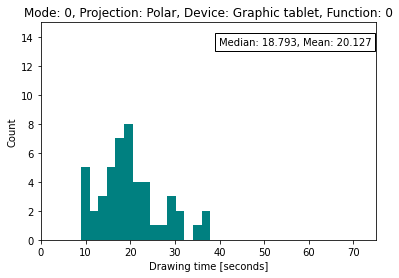

Mean:  20.1271989895625
Median:  18.793413285


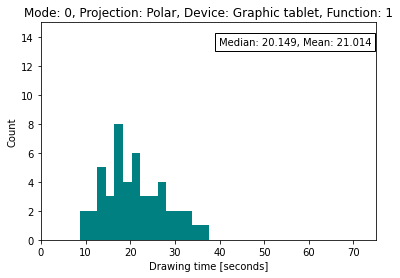

Mean:  21.0144107594375
Median:  20.14886713


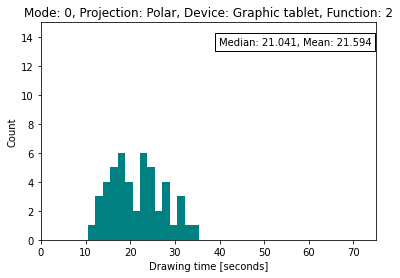

Mean:  21.594449624166668
Median:  21.040962219999997


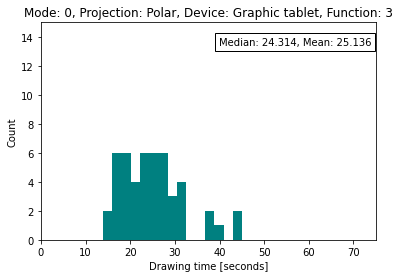

Mean:  25.135678852708335
Median:  24.314448835


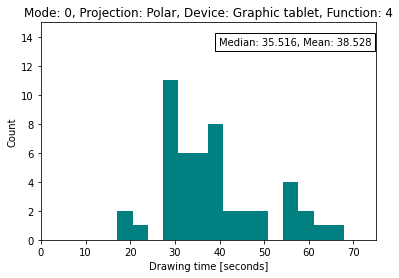

Mean:  38.52831572333333
Median:  35.51634085


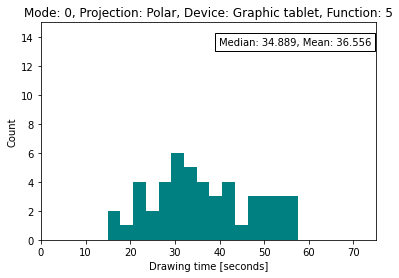

Mean:  36.556435996875
Median:  34.8888489


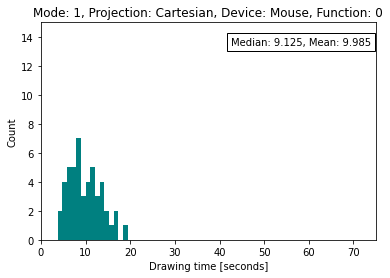

Mean:  9.985332458999999
Median:  9.124977708


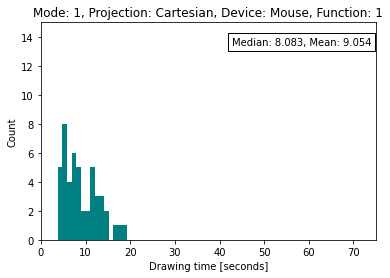

Mean:  9.053879866791666
Median:  8.082934140999999


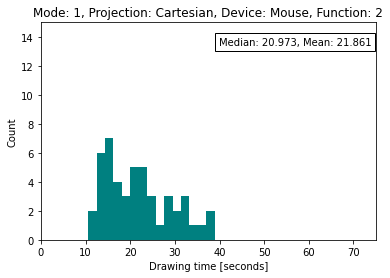

Mean:  21.860873117708334
Median:  20.973311425


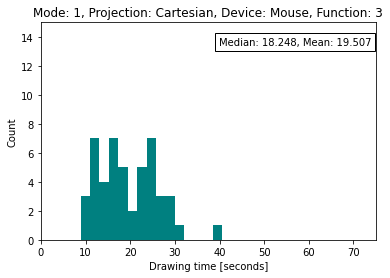

Mean:  19.506553783958335
Median:  18.24788058


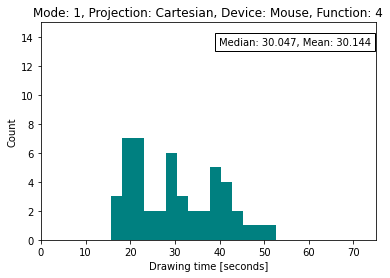

Mean:  30.1443310475
Median:  30.047245739999997


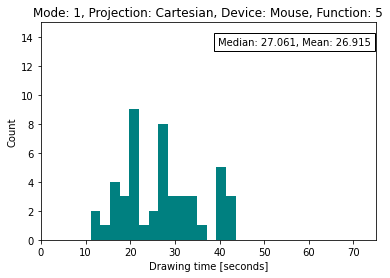

Mean:  26.915239766666662
Median:  27.060524705


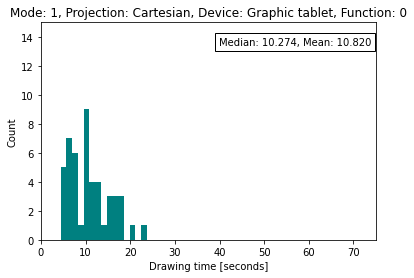

Mean:  10.819806168416667
Median:  10.274055125


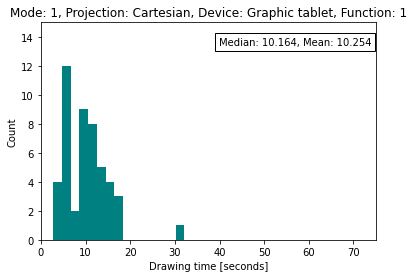

Mean:  10.254482805916668
Median:  10.164058924999999


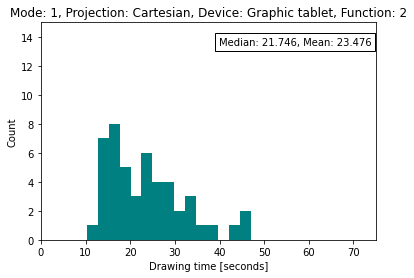

Mean:  23.475666974791665
Median:  21.745634555000002


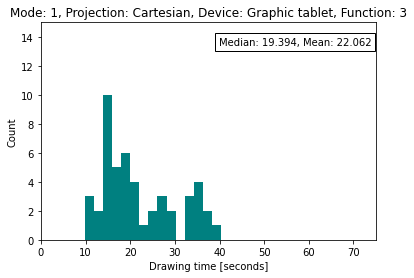

Mean:  22.062356381895835
Median:  19.39394176


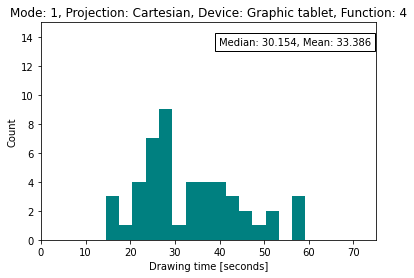

Mean:  33.386455068958334
Median:  30.154205920000003


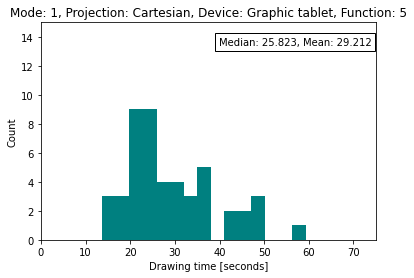

Mean:  29.211554661041664
Median:  25.82271731


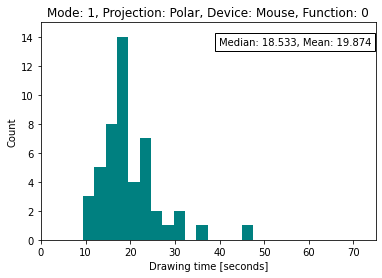

Mean:  19.873787293437502
Median:  18.53343809


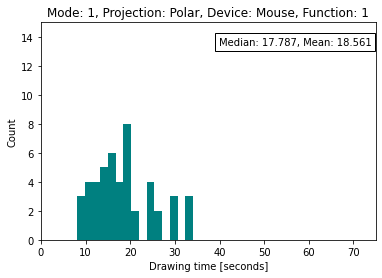

Mean:  18.561386594791667
Median:  17.786787035


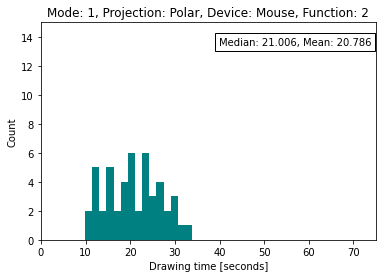

Mean:  20.785790249479167
Median:  21.00619495


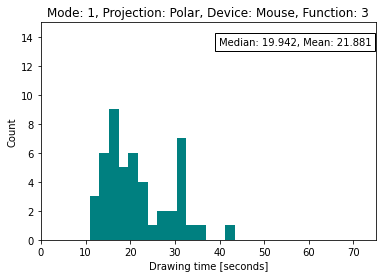

Mean:  21.88144977
Median:  19.94235158


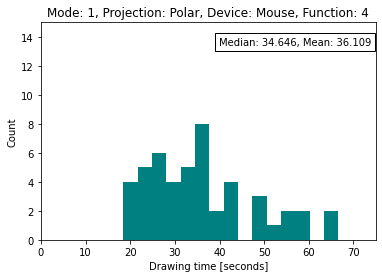

Mean:  36.10873563104167
Median:  34.64632881


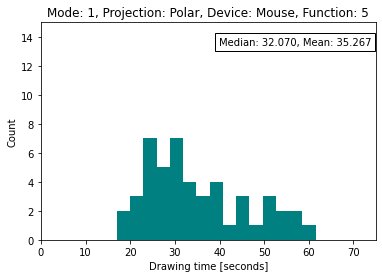

Mean:  35.26743182020834
Median:  32.069736245


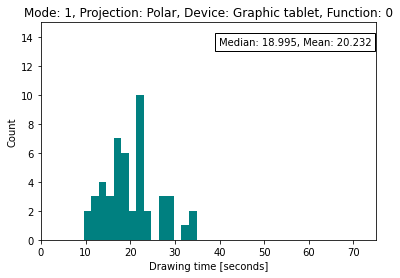

Mean:  20.23155232789583
Median:  18.995462175


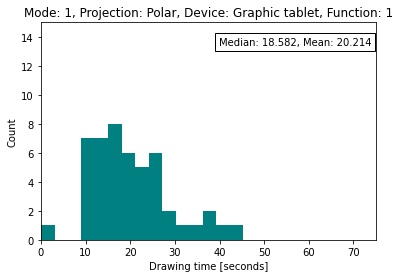

Mean:  20.213697632145834
Median:  18.582342025


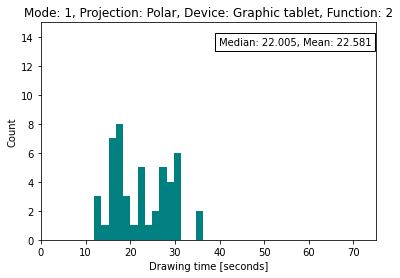

Mean:  22.580721259166666
Median:  22.004709245


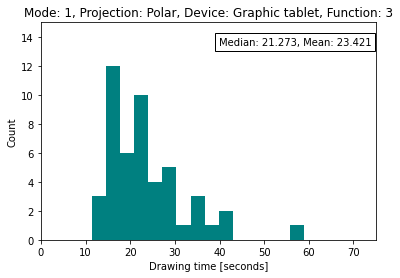

Mean:  23.420964877083332
Median:  21.27338886


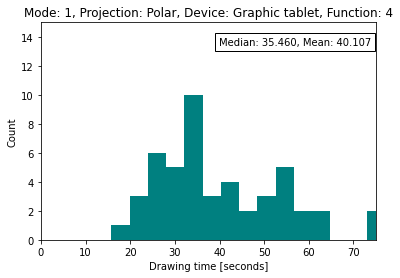

Mean:  40.107453908125
Median:  35.45971835


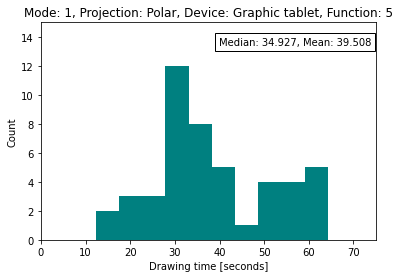

Mean:  39.50805553270834
Median:  34.927266


In [206]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
        # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    drawingTimes = drawingTimes['Drawing time'].values
    
    return drawingTimes

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0

for experimentMode in TEST_MODES:
    for projection in PROJECTIONS:
        for device in DEVICES:
            for funcId in FUNC_IDS:
                dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                plt.figure()
                plt.hist(dts, color="teal", bins=15)
                # limits are hard-coded, if I ever have time, I will make the limits calculation smarter
                xlim = [0, 15]
                ylim = [0, 75]
                plt.ylim(xlim)
                plt.xlim(ylim)
                
                # add text with Median an Mean displayed
                text = "Median: %.3f, Mean: %.3f" % (np.median(dts), np.mean(dts))
                plt.text(ylim[1]-1, xlim[1]-1, text, ha='right', va='top', bbox=dict(facecolor='white', alpha=1))
                
                plt.title(
                    "Mode: %s, Projection: %s, Device: %s, Function: %s"
                     % (experimentMode, projection, device, funcId)
                )
                plt.ylabel("Count")
                plt.xlabel("Drawing time [seconds]")
                saveFigure(
                    drawingTimeHistogramsFolderPath \
                    + "mode-" + str(experimentMode) \
                    + "_device-" + device + \
                    "_function-" + str(funcId) +".png"
                )
                plt.show()
                print("Mean: ", np.mean(dts))
                print("Median: ", np.median(dts))



# Average drawing time for each curve on each input device

In [207]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.mean(drawingTimes) if centralTendency=='mean' else np.median(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes, data=df):
    times = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data)
                    times.append(avg)
    return times

MAX_AVG_DRAW_TIME = round(max(getAvgsByFilter(PROJECTIONS, FUNC_IDS, DEVICES, TEST_MODES)))
MAX_AVG_DRAW_TIME += 0.2 * MAX_AVG_DRAW_TIME

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [208]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in DEVICES:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, MAX_AVG_DRAW_TIME])
            plt.xlim([0, MAX_IOD])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            
            plt.show()

## Test plots

In [209]:
# plotForExperiment([0, 1])

# Linear regression

In [218]:
def getBasePlotTitle(projections, device, experimentModes):
    return "Linear regression for %s, %s, mode=%s,\nCentral Tendency=%s,Index Of Difficulty=%s" \
                   %(projections, device, experimentModes, centralTendency, iodModelName)

def getRegressionCoefficients(reg):
    x1 = 0
    x2 = 1
    y1, y2 = reg.predict(np.array([[x1], [x2]]))
    # Coefficients: y = ax + b
    b = y1
    a = (y2 - y1) / (x2 - x1)
    return a, b

# get x and y data for linear regression
def getDataForRegression(projections, experimentModes, device):
    iods = getIodsAsArray(projections, experimentModes)
    x = [[iod] for iod in iods]

    y = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    return x, y

def getFormattedRegressionMetrics(reg, x, y):
    a, b = getRegressionCoefficients(reg)
    mse = metrics.mean_squared_error(x, y)
    return 'y = %.3fx + %.3f\nR^2 = %.3f\nRMSE = %.3f' % (a, b, reg.score(x, y), np.sqrt(mse))

# model metrics :: for evaulating the regression model
def printRegressionModelMetrics(reg, x, y):
    print(getFormattedRegressionMetrics(reg, x, y))

# training and retrieving the model 
def getRegressionModel(projections, experimentModes, device):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    plotDataAndReg(reg, x, y, getBasePlotTitle(projections, device, experimentModes))
    printRegressionModelMetrics(reg, x, y)

    return reg

def plotDataAndReg(reg, x, y, title):
    plt.figure(figsize=(MAX_IOD / 8, MAX_AVG_DRAW_TIME / 8))
    plt.scatter(x, y, label="Experiment data", color="lightsteelblue", edgecolors="black")

    predictX = np.linspace(1, MAX_IOD, 10)
    predictY = reg.predict([[x] for x in predictX])
    plt.plot(predictX, predictY, color="black", label="Linear regression")
    
    plt.ylabel("Drawing time (seconds)")
    plt.xlabel("Index of difficulty")
    plt.ylim([0, MAX_AVG_DRAW_TIME])
    plt.xlim([0, MAX_IOD])
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title(title)
    
    plt.text(MAX_IOD - 1, 3,
             getFormattedRegressionMetrics(reg, x, y),
             ha='right', va='bottom',
             bbox=dict(facecolor='white', alpha=1)
    )
    
    saveFigure(linearRegressionsFolderPath + title.replace(' ', '_').replace('\n', ''))
    plt.show()

def validateRegressionModel(reg, projections, experimentModes, device):  
    x, y = getDataForRegression(projections, experimentModes, device)
    plotDataAndReg(reg, x, y, getBasePlotTitle(projections, device, experimentModes) + " VALIDATED")
    
    printRegressionModelMetrics(reg, x, y)


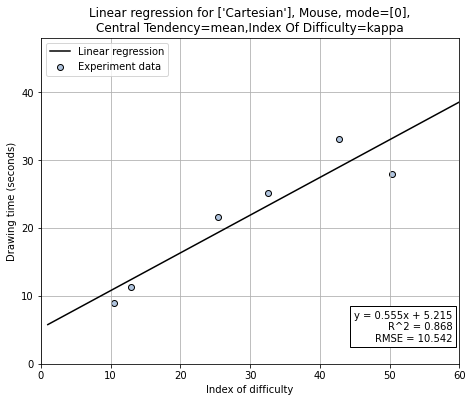

y = 0.555x + 5.215
R^2 = 0.868
RMSE = 10.542


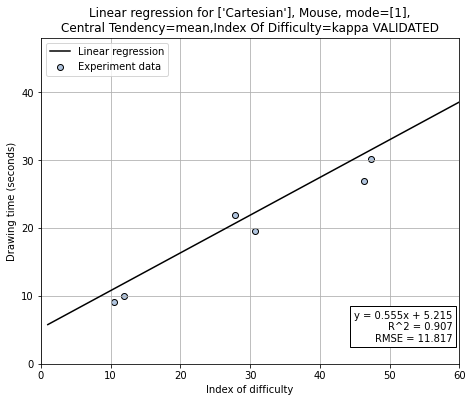

y = 0.555x + 5.215
R^2 = 0.907
RMSE = 11.817


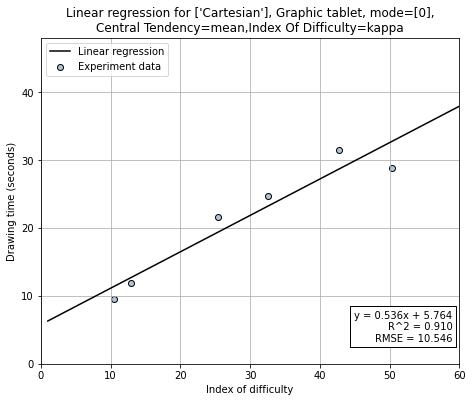

y = 0.536x + 5.764
R^2 = 0.910
RMSE = 10.546


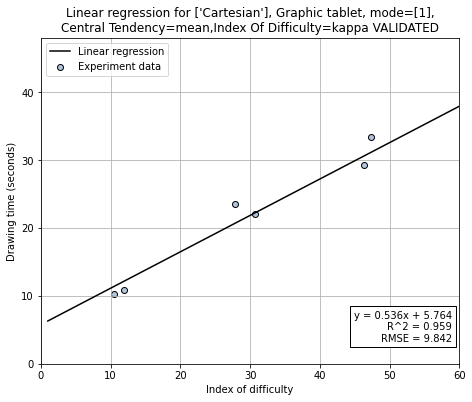

y = 0.536x + 5.764
R^2 = 0.959
RMSE = 9.842


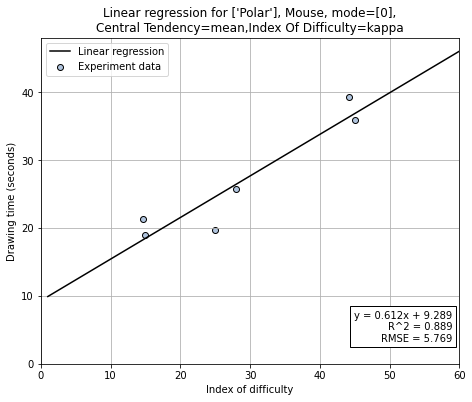

y = 0.612x + 9.289
R^2 = 0.889
RMSE = 5.769


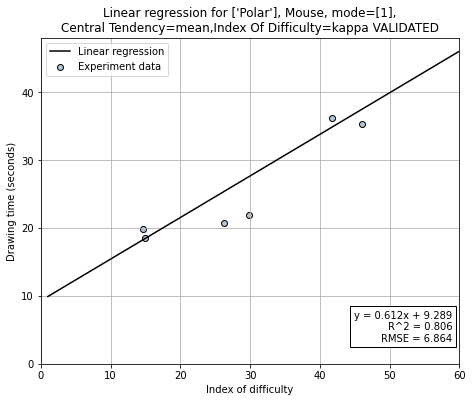

y = 0.612x + 9.289
R^2 = 0.806
RMSE = 6.864


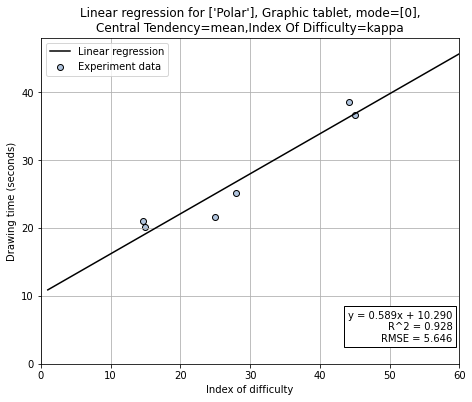

y = 0.589x + 10.290
R^2 = 0.928
RMSE = 5.646


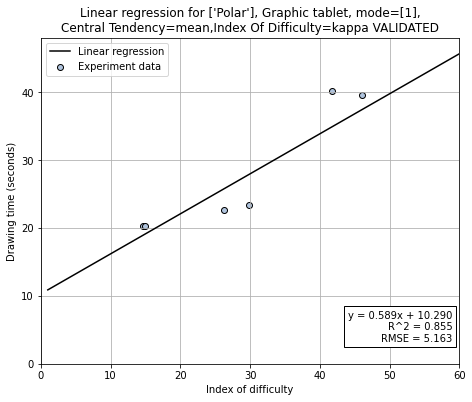

y = 0.589x + 10.290
R^2 = 0.855
RMSE = 5.163


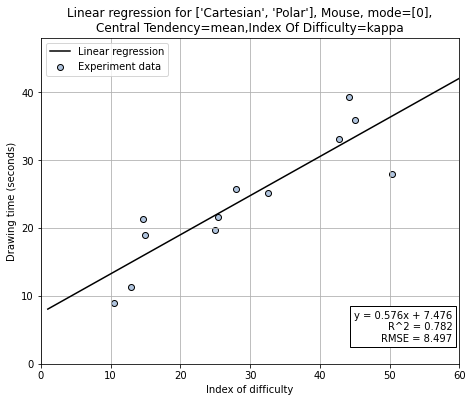

y = 0.576x + 7.476
R^2 = 0.782
RMSE = 8.497


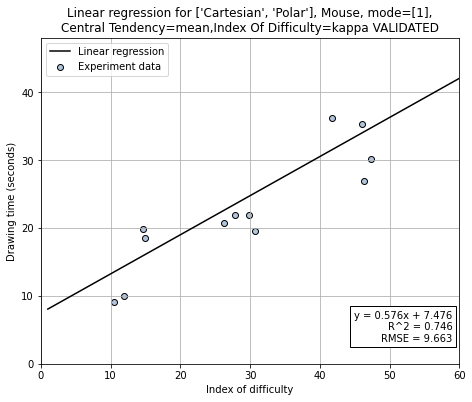

y = 0.576x + 7.476
R^2 = 0.746
RMSE = 9.663


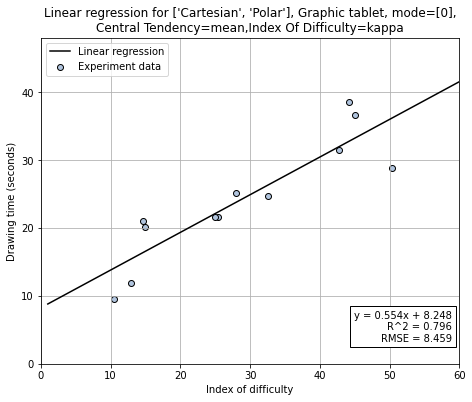

y = 0.554x + 8.248
R^2 = 0.796
RMSE = 8.459


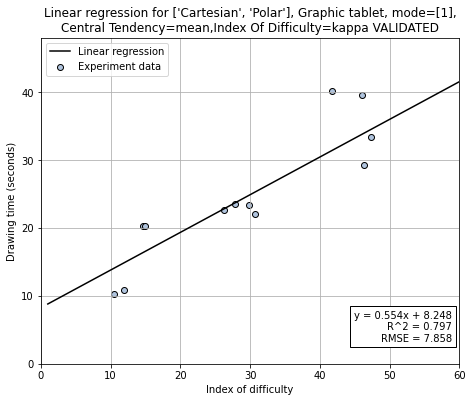

y = 0.554x + 8.248
R^2 = 0.797
RMSE = 7.858


In [219]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        reg = getRegressionModel(projections, [0], device)
        validateRegressionModel(reg, projections, [1], device)
        
        #reg2 = getRegressionModel(projections, [0, 1], device)
        # test the residuals as shown here: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

# Participant data

Number of participants: 24
Average participant age: 23.542
Standard deviation: 1.154

 ::::
Number of Left-handed participants: 3
Percentage of Left-handed participants 12.5 %
Number of Right-handed participants: 21
Percentage of Right-handed participants 87.5 %
Number of Ambidextrous participants: 0
Percentage of Ambidextrous participants 0.0 %

 ::::
Number of expert graphic tablet participants: 1
Percentage of expert graphic tablet participants 4.2 %
Number of expert mouse participants: 24
Percentage of expert graphic tablet participants 100.0 %

 ::::
Average drawing times
Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Mouse;['Cartesian'];15.358;5.2655
Mateja Napravnik;Mouse;['Cartesian'];19.5263;9.6693
SadilaJeMare;Mouse;['Cartesian'];18.0791;9.625
Shanko;Mouse;['Cartesian'];29.4701;12.459
Vrtni_Patuljak;Mouse;['Cartesian'];18.2788;9.9836
Zmaj Zemun;Mouse;['Cartesian'];20.3741;8.5857
aronta;Mouse;['Cartesian'];14.4917;6.7344
asubasic

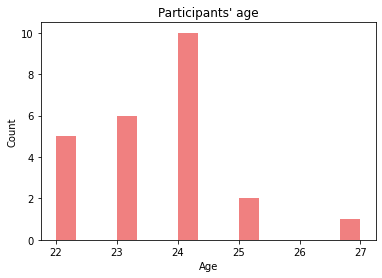

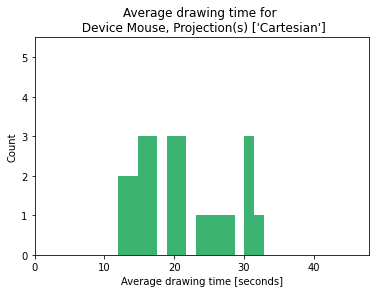

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Mouse;['Polar'];19.9648;5.5281
Mateja Napravnik;Mouse;['Polar'];24.3985;9.9621
SadilaJeMare;Mouse;['Polar'];22.8567;9.6175
Shanko;Mouse;['Polar'];34.2738;11.2625
Vrtni_Patuljak;Mouse;['Polar'];22.0537;8.7548
Zmaj Zemun;Mouse;['Polar'];25.5451;9.3927
aronta;Mouse;['Polar'];19.2916;5.1497
asubasic;Mouse;['Polar'];23.5645;5.7286
azahtila;Mouse;['Polar'];27.0896;7.139
bado97;Mouse;['Polar'];44.3422;11.4618
dgrdinic;Mouse;['Polar'];17.0537;6.6936
dmakar;Mouse;['Polar'];23.0333;6.6646
kfilipcic;Mouse;['Polar'];31.7582;8.5222
kknezic;Mouse;['Polar'];18.3206;5.9823
kskunca;Mouse;['Polar'];35.3375;12.7579
lotovic;Mouse;['Polar'];22.4192;5.7002
mdudic;Mouse;['Polar'];37.2335;12.0157
mduvnjak;Mouse;['Polar'];35.6362;8.4965
mnjiric;Mouse;['Polar'];21.7679;6.201
mrGauss;Mouse;['Polar'];32.3636;15.7028
mtvrdinic;Mouse;['Polar'];20.562;8.9765
rpolic;Mouse;['Polar'];30.9901;10.285
ssimunic;Mouse;['Polar'];16

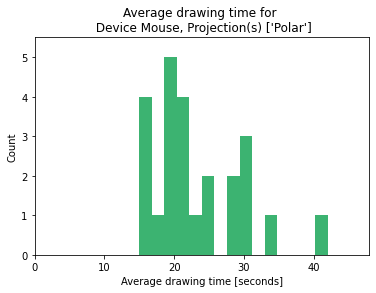

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Mouse;['Cartesian', 'Polar'];17.6614;5.8692
Mateja Napravnik;Mouse;['Cartesian', 'Polar'];21.9624;10.1145
SadilaJeMare;Mouse;['Cartesian', 'Polar'];20.4679;9.9134
Shanko;Mouse;['Cartesian', 'Polar'];31.872;12.1163
Vrtni_Patuljak;Mouse;['Cartesian', 'Polar'];20.1662;9.5771
Zmaj Zemun;Mouse;['Cartesian', 'Polar'];22.9596;9.3623
aronta;Mouse;['Cartesian', 'Polar'];16.8916;6.4572
asubasic;Mouse;['Cartesian', 'Polar'];21.429;6.6917
azahtila;Mouse;['Cartesian', 'Polar'];24.6016;7.453
bado97;Mouse;['Cartesian', 'Polar'];36.8803;14.1542
dgrdinic;Mouse;['Cartesian', 'Polar'];15.9936;6.9132
dmakar;Mouse;['Cartesian', 'Polar'];21.5887;8.6119
kfilipcic;Mouse;['Cartesian', 'Polar'];28.7342;9.1443
kknezic;Mouse;['Cartesian', 'Polar'];15.9002;6.4861
kskunca;Mouse;['Cartesian', 'Polar'];31.4228;12.8021
lotovic;Mouse;['Cartesian', 'Polar'];20.7943;6.7914
mdudic;Mouse;['Cartesian', 'Polar'];32.9721;13.0969
mdu

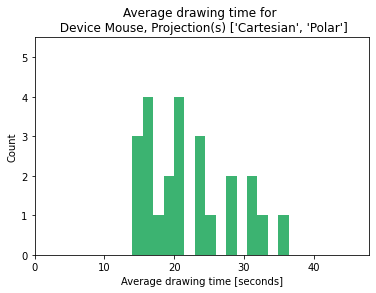

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Graphic tablet;['Cartesian'];20.2904;8.0597
Mateja Napravnik;Graphic tablet;['Cartesian'];17.4942;8.4386
SadilaJeMare;Graphic tablet;['Cartesian'];13.6763;5.3657
Shanko;Graphic tablet;['Cartesian'];30.0038;11.4124
Vrtni_Patuljak;Graphic tablet;['Cartesian'];26.1509;14.1355
Zmaj Zemun;Graphic tablet;['Cartesian'];20.1896;9.4147
aronta;Graphic tablet;['Cartesian'];16.281;6.3539
asubasic;Graphic tablet;['Cartesian'];23.8004;7.7907
azahtila;Graphic tablet;['Cartesian'];20.6172;7.0761
bado97;Graphic tablet;['Cartesian'];33.7857;12.9749
dgrdinic;Graphic tablet;['Cartesian'];13.1479;6.1754
dmakar;Graphic tablet;['Cartesian'];16.3041;7.7467
kfilipcic;Graphic tablet;['Cartesian'];23.2717;8.7029
kknezic;Graphic tablet;['Cartesian'];16.407;6.6898
kskunca;Graphic tablet;['Cartesian'];29.6773;11.7109
lotovic;Graphic tablet;['Cartesian'];22.1063;8.7518
mdudic;Graphic tablet;['Cartesian'];28.4564;12.4975
md

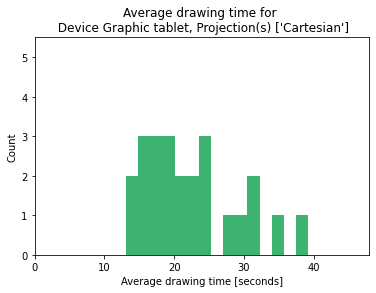

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Graphic tablet;['Polar'];25.0728;5.9738
Mateja Napravnik;Graphic tablet;['Polar'];22.5283;11.4052
SadilaJeMare;Graphic tablet;['Polar'];20.0042;5.812
Shanko;Graphic tablet;['Polar'];37.8811;10.9791
Vrtni_Patuljak;Graphic tablet;['Polar'];31.1358;12.0711
Zmaj Zemun;Graphic tablet;['Polar'];25.4128;9.1052
aronta;Graphic tablet;['Polar'];20.8275;5.5585
asubasic;Graphic tablet;['Polar'];31.5795;7.8221
azahtila;Graphic tablet;['Polar'];25.4349;7.4261
bado97;Graphic tablet;['Polar'];43.2203;12.5531
dgrdinic;Graphic tablet;['Polar'];15.1261;4.2186
dmakar;Graphic tablet;['Polar'];21.6683;6.4491
kfilipcic;Graphic tablet;['Polar'];28.6341;8.5049
kknezic;Graphic tablet;['Polar'];20.9383;6.995
kskunca;Graphic tablet;['Polar'];37.1722;15.3838
lotovic;Graphic tablet;['Polar'];27.452;6.5433
mdudic;Graphic tablet;['Polar'];36.8806;11.3361
mduvnjak;Graphic tablet;['Polar'];40.1985;13.7058
mnjiric;Graphic tabl

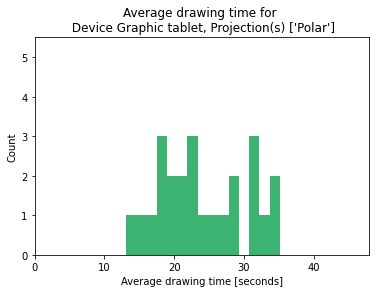

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Marin_Vidakovic_Lipovac;Graphic tablet;['Cartesian', 'Polar'];22.6816;7.486
Mateja Napravnik;Graphic tablet;['Cartesian', 'Polar'];20.0112;10.3431
SadilaJeMare;Graphic tablet;['Cartesian', 'Polar'];16.8403;6.4262
Shanko;Graphic tablet;['Cartesian', 'Polar'];33.9424;11.8703
Vrtni_Patuljak;Graphic tablet;['Cartesian', 'Polar'];28.6434;13.3781
Zmaj Zemun;Graphic tablet;['Cartesian', 'Polar'];22.8012;9.6224
aronta;Graphic tablet;['Cartesian', 'Polar'];18.5542;6.3876
asubasic;Graphic tablet;['Cartesian', 'Polar'];27.69;8.7218
azahtila;Graphic tablet;['Cartesian', 'Polar'];23.026;7.6427
bado97;Graphic tablet;['Cartesian', 'Polar'];38.503;13.6094
dgrdinic;Graphic tablet;['Cartesian', 'Polar'];14.137;5.38
dmakar;Graphic tablet;['Cartesian', 'Polar'];18.9862;7.6154
kfilipcic;Graphic tablet;['Cartesian', 'Polar'];25.9529;9.0126
kknezic;Graphic tablet;['Cartesian', 'Polar'];18.6726;7.2093
kskunca;Graphic tablet;['Cartesian', '

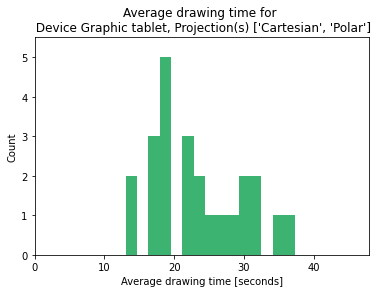

In [249]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
handednessFreq = {
    "Left-handed": 0,
    "Right-handed": 0,
    "Ambidextrous": 0
}
hasExpWTablet = 0
hasExpWMouse = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    handednessFreq[row['Participant handedness'].values[0]] += 1
    hasExpWTablet += row['Expert Graphic Tablet User'].values[0]
    hasExpWMouse += row['Expert Mouse User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages, color="lightcoral", bins=15)
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
saveFigure(participantDataFolderPath + "participant_age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")

for handedness in handednessFreq:
    freq = handednessFreq[handedness]
    print("Number of " + handedness + " participants:", freq)
    print("Percentage of " + handedness + " participants", round(freq * 1.0 / len(participants), 3)*100, '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3)*100, '%'
)

print("Number of expert mouse participants:", hasExpWMouse)
print("Percentage of expert graphic tablet participants",
      round(hasExpWMouse * 1.0 / len(participants), 3)*100, '%'
)

print("\n ::::")
print("Average drawing times")
# Average drawing time per user
sortedParticipants = sorted(participants)
for device in DEVICES:
    for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time variance", sep=";")
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes = getAvgsByFilter(projections, [funcId], [device], [experimentMode], drawingTimes)
                    dts.append(drawingTimes)
            print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=';')
            pltData.append(np.median(dts))
        # print()
        plt.figure()
        plt.hist(pltData, color='mediumseagreen', bins=15)
        title = "Average drawing time for \n Device %s, Projection(s) %s" %(device, projections)
        plt.title(title)
        plt.ylabel("Count")
        plt.xlabel("Average drawing time [seconds]")
        
        # this lim is hard-coded. if I ever have time, I should make this soft-coded :)
        plt.ylim([0, 5.5])
        plt.xlim([0, MAX_AVG_DRAW_TIME])
        
        saveFigure(participantDataFolderPath + title)
        plt.show()
            


## Error approximation

In [262]:
sortedParticipants = sorted(participants)

print("Participant index, Mouse mean, Mouse stdev, Graphic tablet mean, Graphic tablet stdev")
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=",", end='')
        avgs[device].append(np.mean(epms))
    print()

Participant index, Mouse mean, Mouse stdev, Graphic tablet mean, Graphic tablet stdev
Marin_Vidakovic_Lipovac,0.030788,0.011263,0.030708,0.012842
Mateja Napravnik,0.02598,0.008112,0.028455,0.008879
SadilaJeMare,0.027604,0.010104,0.036846,0.014934
Shanko,0.018446,0.005908,0.018798,0.006488
Vrtni_Patuljak,0.028721,0.010888,0.028007,0.010928
Zmaj Zemun,0.022296,0.007368,0.028141,0.011593
aronta,0.025591,0.011881,0.035557,0.016128
asubasic,0.022956,0.008043,0.025117,0.009229
azahtila,0.022429,0.008087,0.024291,0.009475
bado97,0.018823,0.006911,0.023162,0.007969
dgrdinic,0.026961,0.015374,0.036031,0.017865
dmakar,0.025251,0.009425,0.034391,0.015538
kfilipcic,0.02042,0.007781,0.022104,0.009983
kknezic,0.031666,0.010652,0.033651,0.011138
kskunca,0.020906,0.007445,0.023608,0.009039
lotovic,0.02588,0.00977,0.029385,0.009761
mdudic,0.01994,0.007049,0.020253,0.006187
mduvnjak,0.019522,0.007279,0.023437,0.008675
mnjiric,0.024718,0.008685,0.028142,0.010692
mrGauss,0.015222,0.004917,0.014639,0.00446

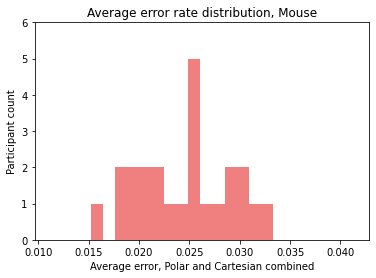

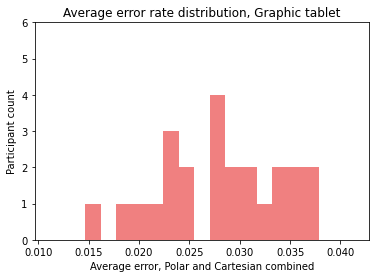

In [261]:
maxAvg = np.max([np.max(avgs["Mouse"]), np.max(avgs["Graphic tablet"])])
minAvg = np.min([np.min(avgs["Mouse"]), np.min(avgs["Graphic tablet"])])
xlim = [minAvg - 0.005, maxAvg + 0.005]
    
plt.figure()
plt.hist(avgs["Mouse"], color="lightcoral", bins=15)
title = "Average error rate distribution, Mouse"
plt.title(title)
plt.xlabel("Average error, Polar and Cartesian combined")
plt.ylabel("Participant count")
plt.ylim([0, 6])
plt.xlim(xlim)
saveFigure(participantDataFolderPath + title)
plt.show()

plt.figure()
plt.hist(avgs["Graphic tablet"], color="lightcoral", bins=15)
title = "Average error rate distribution, Graphic tablet"
plt.title(title)
plt.xlabel("Average error, Polar and Cartesian combined")
plt.ylabel("Participant count")
plt.ylim([0, 6])
plt.xlim(xlim)
saveFigure(participantDataFolderPath + title)
plt.show()